# Step #1 Load the Data

In [2]:
# Setting up packages for data manipulation and machine learning
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import svm

# Source: 
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques

path = "https://raw.githubusercontent.com/flo7up/relataly_data/main/house_prices/train.csv"
df = pd.read_csv(path)
df_base = df.copy()
df_base.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Step #2 Exploring the Data

KeyError: 'Churn'

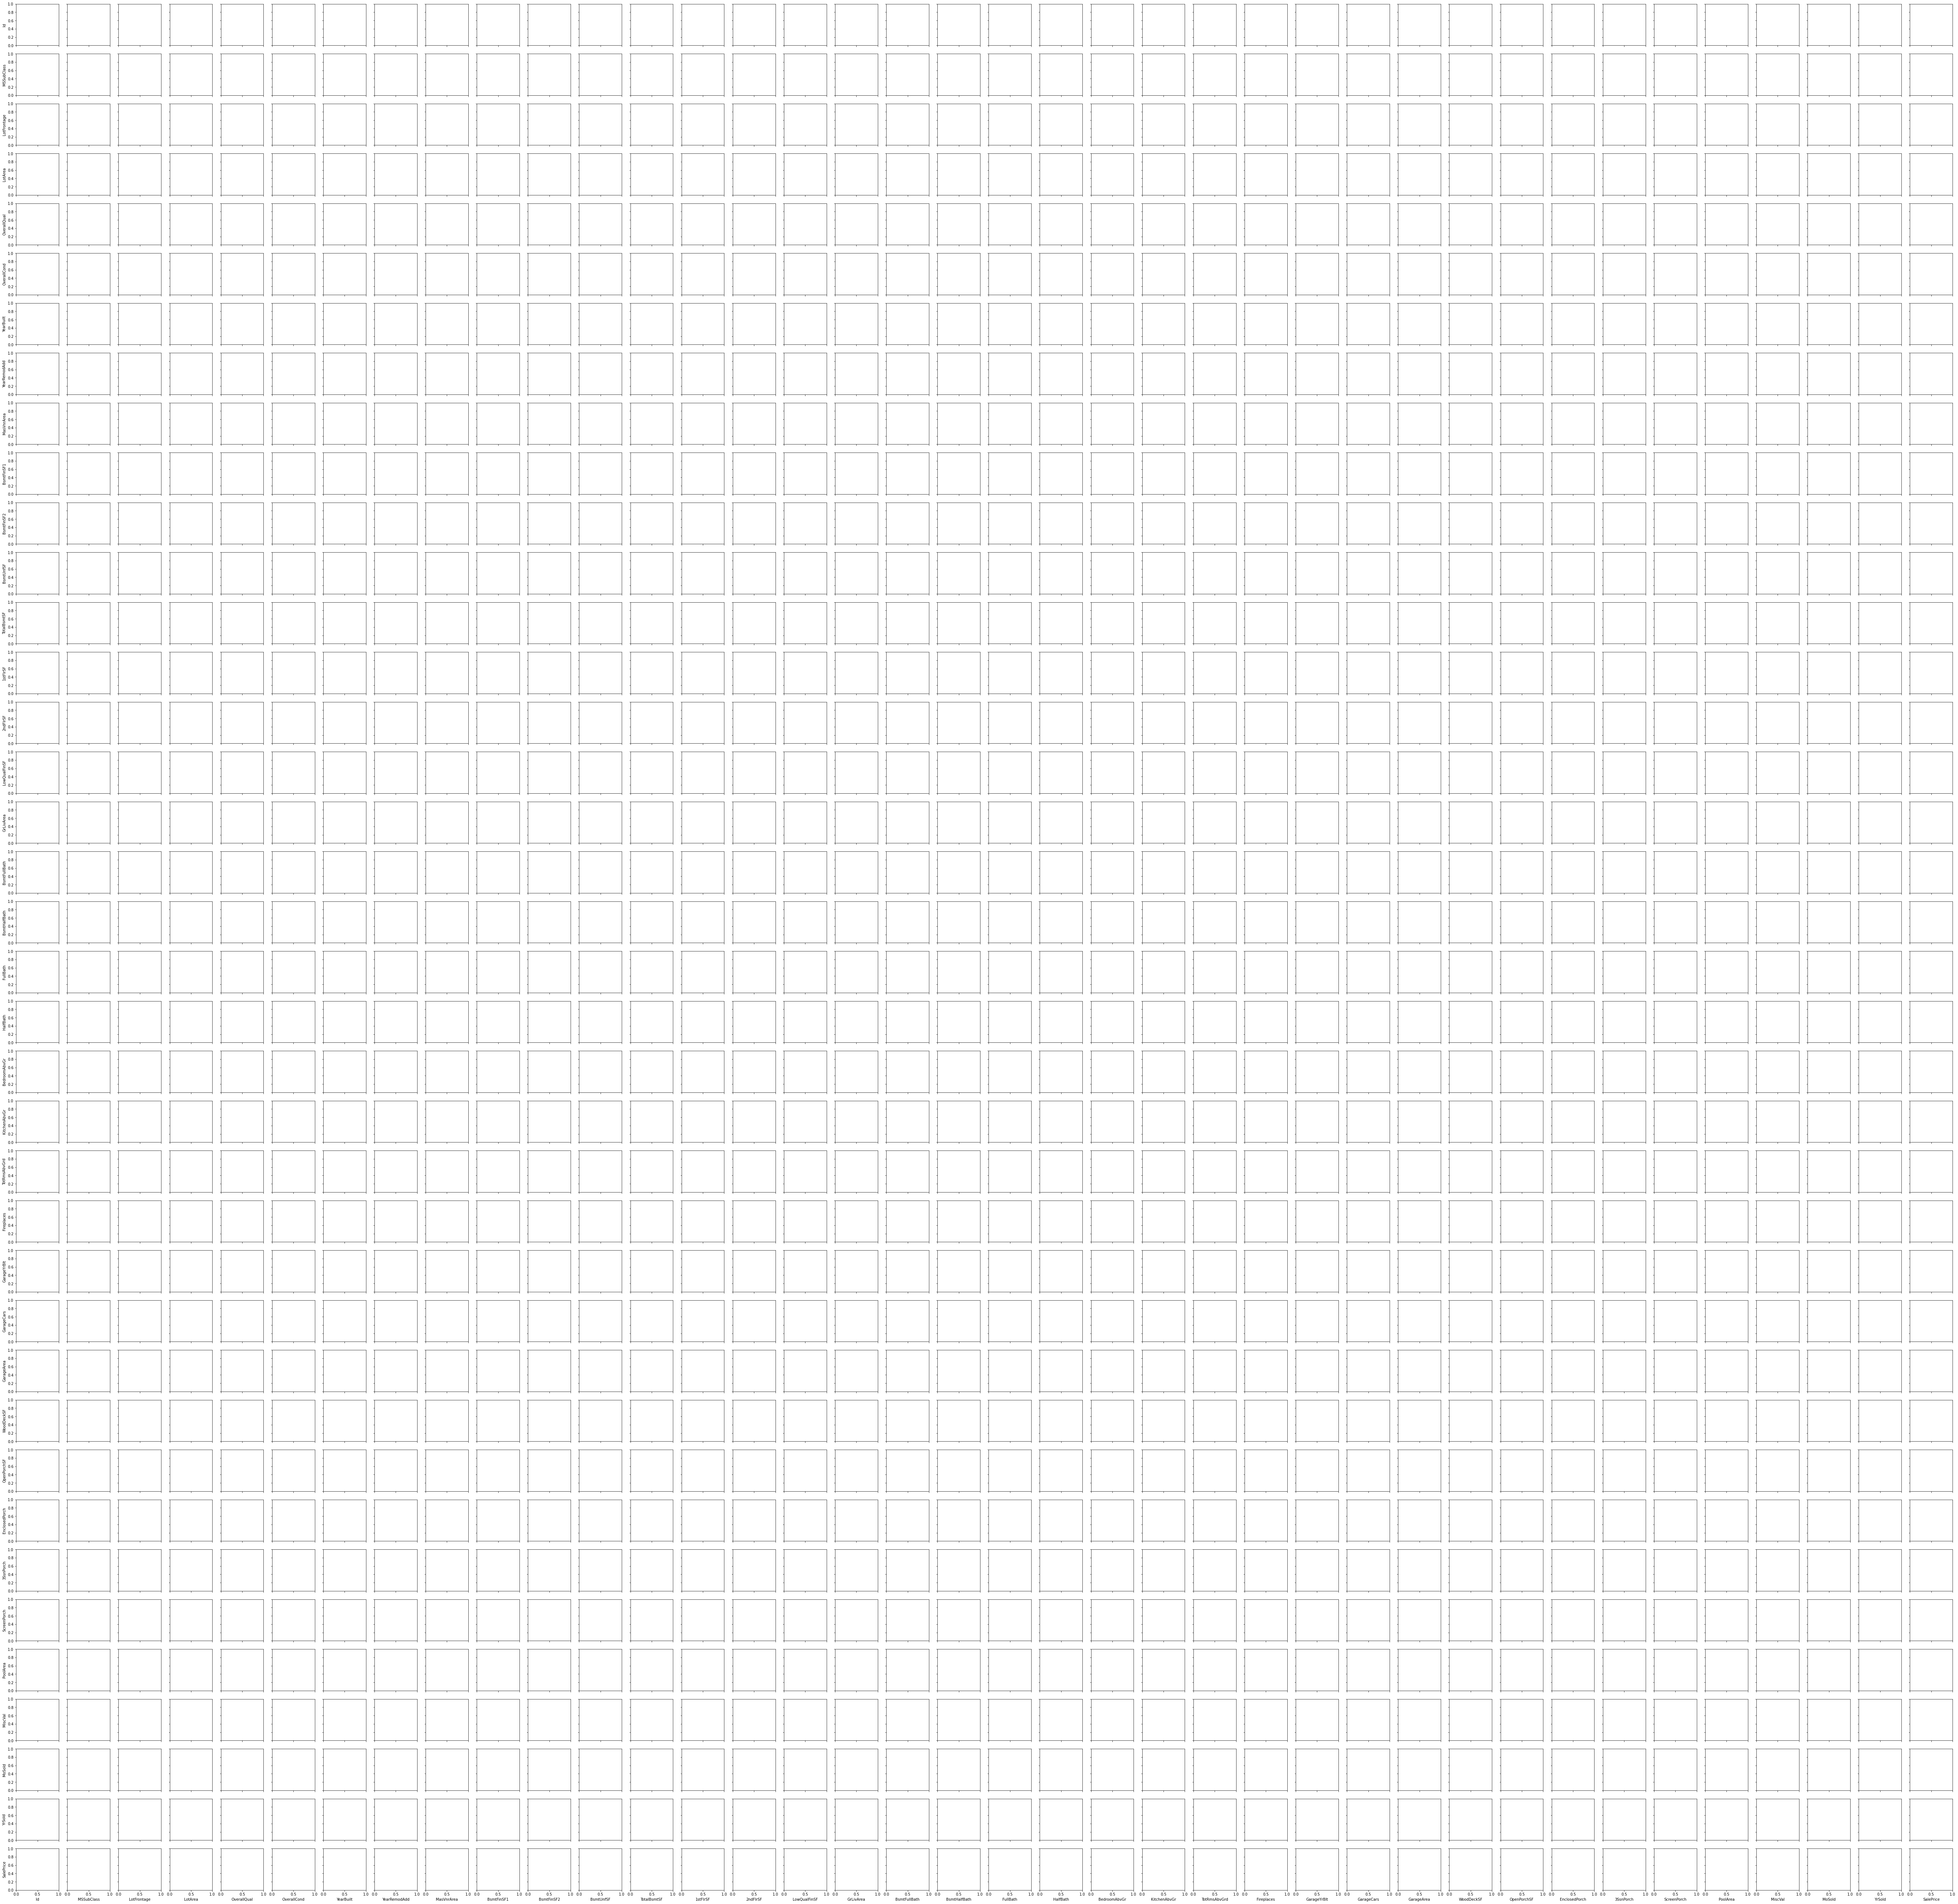

In [4]:
# # Create histograms for feature columns separated by prediction label value
df_houseprices = df_base.copy()

# class_columnname = 'Churn'
sns.pairplot(df_houseprices, hue="Churn", height=2.5)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


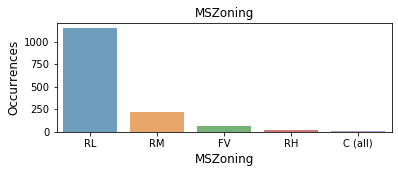

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64


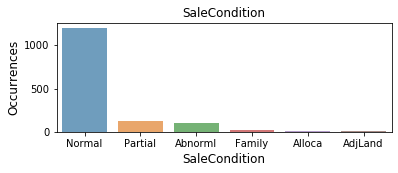

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64


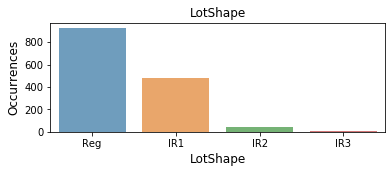

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64


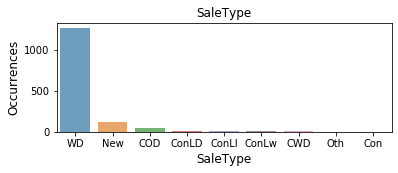

Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64


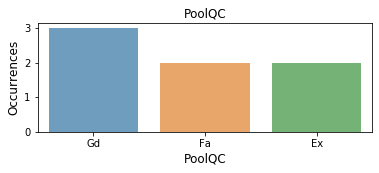

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


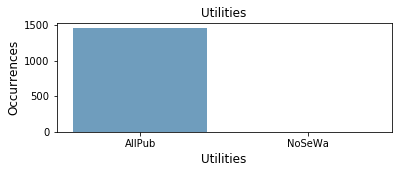

In [3]:
# Histograms for numeric variables
def printvaluecount(df, column_name):
    df_column = df[column_name].value_counts()
    print(df_column)
    plt.figure(figsize=(6, 2))
    sns.barplot(x=df_column.index, y=df_column.values, alpha=0.7)
    plt.title(column_name)
    plt.ylabel('Occurrences', fontsize=12)
    plt.xlabel(column_name, fontsize=12)
    plt.show()

columnnames = ['MSZoning', 'SaleCondition', 'LotShape', 'SaleType', 'PoolQC', 'Utilities']
for i in columnnames:
    printvaluecount(df_base, i)

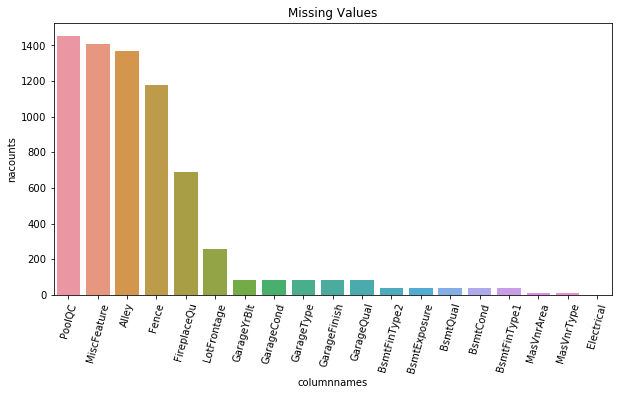

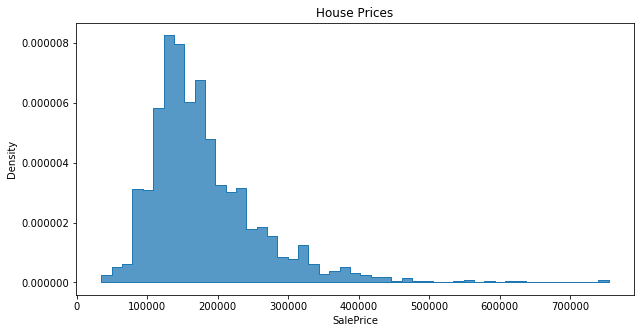

In [4]:
# Print NA Values for Categorical Columns
counts = df.isna().sum()
data = {'columnnames':counts.index.values, 'nacounts':counts.values}
plt.figure(figsize=(10, 5))
plt.xticks(rotation=75)
plt.title('Missing Values')
df_na_counts = pd.DataFrame(data).sort_values(by='nacounts', ascending=False)
df_na_counts_filtered = df_na_counts[df_na_counts['nacounts'] > 0]
sns.barplot(y='nacounts', x='columnnames', orient='v', data=df_na_counts_filtered)

# Histogram of House Prices
plt.figure(figsize=(10, 5))
plt.title('House Prices')
sns.histplot(data=df['SalePrice'], element="step", stat="density", common_norm=False)

# Step #3 Preprocessing

In [5]:
def preprocessFeatures(df):
    # Time Feature Engineering
    df_prep = df.copy()
    df_prep = pd.get_dummies(df[['MSZoning' , 'SaleCondition', 'LotShape', 'Utilities', 'SaleType', 'PoolQC']])
    
    df_prep = df_prep.dropna()
    return df_prep

df_prep = preprocessFeatures(df)

6 Train a Random Decision Forest Classifier

# Step #4 The Standard Way of Training a Model

Mean Absolute Percentage Error (MAPE): 26.67 %
Median Absolute Percentage Error (MDAPE): 22.73 %


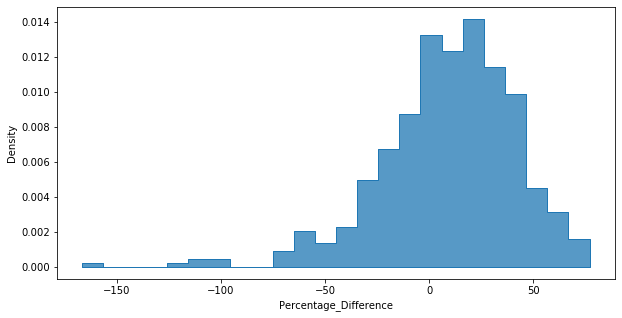

In [6]:
# Separate the prediction values from the training data
X_df = df_prep.copy()
y_df = df['SalePrice'].values

# Split the data into x_train and y_train data sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, train_size=0.7, random_state=0)

# Train a Prediction Model
clf = svm.SVC()
clf.fit(X_train, y_train)

# Make Predictions on the Testset
predictions = clf.predict(X_test)

# Measure Performance of the Prediction Model
def measurePerformance(predictions, y_test):
    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.round(np.mean((np.abs(np.subtract(y_test, predictions)/ y_test))) * 100, 2)
    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.round(np.median((np.abs(np.subtract(y_test, predictions)/ y_test)) ) * 100, 2)
    return MAPE, MDAPE

def residualHistplot(predictions, y_test):
    df_pred_real = pd.DataFrame({'SalesPrice': y_test, 'Prediction': predictions, 'Percentage_Difference': (y_test - predictions) * 100/ y_test}).sort_values(by='Percentage_Difference', ascending=False)
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_pred_real['Percentage_Difference'], element="step", stat="density", common_norm=False)

MAPE, MDAPE = measurePerformance(predictions, y_test)
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
residualHistplot(predictions, y_test)    

# Step #5 K-Fold Cross Validation

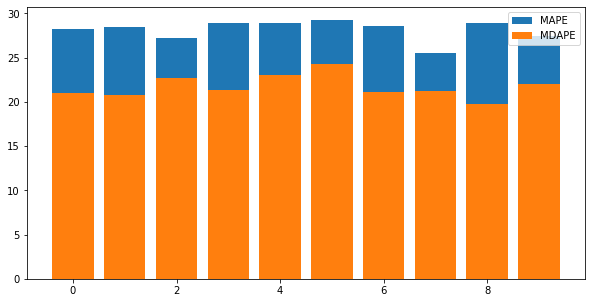

Average Mean Absolute Percentage Error (MDAPE): 28.139 %
Average Median Absolute Percentage Error (MDAPE): 21.719 %


In [7]:
# Seperate the prediction values from the training data
X_df = df_prep.copy()
y_df = df['SalePrice']

t = 1
MAPE_list, MDAPE_list = [], []
# Split the Data into K-Folds and Train a separate Prediction Model for each fold
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=123)
for n_train, n_test in rkf.split(X_df):
    #print("%s %s" % (n_train, n_test))
    X_train, y_train = X_df.iloc[n_train], y_df.iloc[n_train]
    X_test, y_test = X_df.iloc[n_test], y_df.iloc[n_test]

    clf = svm.SVC()
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    MAPE, MDAPE = measurePerformance(predictions, y_test)
    MAPE_list.append(MAPE)
    MDAPE_list.append(MDAPE)
    t += 1
    
    #residualHistplot(predictions, y_test)    

#MDAPE_list
plt.figure(figsize=(10, 5))
plt.bar(x= range(0,len(MAPE_list)), height=MAPE_list, label='MAPE')
plt.bar(x= range(0,len(MDAPE_list)), height=MDAPE_list, label='MDAPE')
plt.legend()
plt.show()

print(f'Average Mean Absolute Percentage Error (MDAPE): {np.array(MAPE_list).mean()} %')
print(f'Average Median Absolute Percentage Error (MDAPE): {np.array(MDAPE_list).mean()} %')